# Data Set Information:

Features are extracted from electric current drive signals. The drive has intact and defective components. This results in 11 different classes with different conditions. Each condition has been measured several times by 12 different operating conditions, this means by different speeds, load moments and load forces. The current signals are measured with a current probe and an oscilloscope on two phases.


# Attribute Information:

The Empirical Mode Decomposition (EMD) was used to generate a new database for the generation of features. The first three intrinsic mode functions (IMF) of the two phase currents and their residuals (RES) were used and broken down into sub-sequences. For each of this sub-sequences, the statistical features mean, standard deviation, skewness and kurtosis were calculated.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv('Sensorless_drive_diagnosis.txt', sep = ' ', header = None)
print(df.shape)
df.head()

(58509, 49)


,0,1,2,3,4,5,6,7,8,9,...,39,40,41,42,43,44,45,46,47,48
0,-3.014600e-07,8.260300e-06,-0.000012,-0.000002,-1.438600e-06,-0.000021,0.031718,0.031710,0.031721,-0.032963,...,-0.63308,2.9646,8.1198,-1.4961,-1.4961,-1.4961,-1.4996,-1.4996,-1.4996,1
1,2.913200e-06,-5.247700e-06,0.000003,-0.000006,2.778900e-06,-0.000004,0.030804,0.030810,0.030806,-0.033520,...,-0.59314,7.6252,6.1690,-1.4967,-1.4967,-1.4967,-1.5005,-1.5005,-1.5005,1
2,-2.951700e-06,-3.184000e-06,-0.000016,-0.000001,-1.575300e-06,0.000017,0.032877,0.032880,0.032896,-0.029834,...,-0.63252,2.7784,5.3017,-1.4983,-1.4983,-1.4982,-1.4985,-1.4985,-1.4985,1
3,-1.322600e-06,8.820100e-06,-0.000016,-0.000005,-7.282900e-07,0.000004,0.029410,0.029401,0.029417,-0.030156,...,-0.62289,6.5534,6.2606,-1.4963,-1.4963,-1.4963,-1.4975,-1.4975,-1.4976,1
4,-6.836600e-08,5.666300e-07,-0.000026,-0.000006,-7.940600e-07,0.000013,0.030119,0.030119,0.030145,-0.031393,...,-0.63010,4.5155,9.5231,-1.4958,-1.4958,-1.4958,-1.4959,-1.4959,-1.4959,1


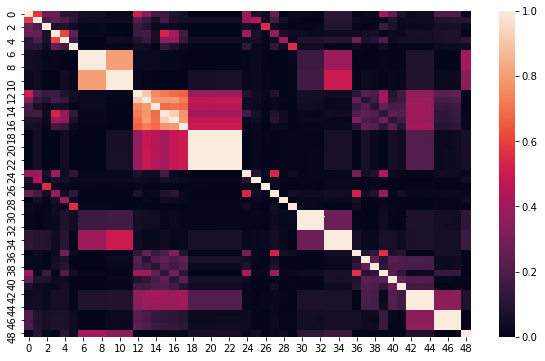

In [4]:
plt.figure(figsize = (10,6))
sns.heatmap(abs(df.corr()), vmin = 0, vmax = 1)
plt.show()

- Lighter the cell, higher the correlation
- There is a near 100% multi-collinearity among a few variables

In [5]:
np.array(df.isna().sum())

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0])

- None of the columns have any missing values

In [6]:
df.dtypes.value_counts()

float64    48
int64       1
dtype: int64

- All the independent variables are float type and the dependent variable is of integer type

In [7]:
X = df.iloc[:,:-1]
y = df.iloc[:, -1]
y.value_counts()

1     5319
2     5319
3     5319
4     5319
5     5319
6     5319
7     5319
8     5319
9     5319
10    5319
11    5319
Name: 48, dtype: int64

- We have a balance distribution of 11 classes

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify = y, random_state=1)

In [9]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [10]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=1)

dt.fit(X_train, y_train)

DecisionTreeClassifier(random_state=1)

In [11]:
score1 = dt.score(X_test, y_test)
score1

0.9829094886519004

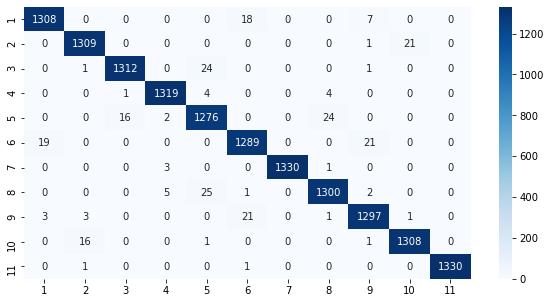

In [12]:
from sklearn.metrics import confusion_matrix

plt.figure(figsize=(10, 5))

sns.heatmap(pd.DataFrame(confusion_matrix(dt.predict(X_test), y_test), 
                         index = range(1,12), columns = range(1,12)),
            vmin = 0, cmap='Blues', annot=True, fmt='g')

plt.show()

In [13]:
a = pd.DataFrame(dt.feature_importances_, columns = ['importance'], index=X.columns).sort_values('importance', ascending = False)
a.index.name = 'Feature'
a['cummulative_importance'] = np.cumsum(a.importance)
most_imp = a[a['cummulative_importance'] <= .95]
print(len(most_imp))
most_imp

15


,importance,cummulative_importance
Feature,,
10,0.339250,0.339250
6,0.156563,0.495813
11,0.135164,0.630977
8,0.101601,0.732578
24,0.042576,0.775154
12,0.021186,0.796340
19,0.019801,0.816141
21,0.019742,0.835883
35,0.019251,0.855134


- The above are variables sorted by their importances, based on how good a role they played in reducing the impurity at every split
- The 15 features do almost 95% of the job
- Try to train a DT model using only these 15 features and observe the performance
- Let's consider only those features further on

In [14]:
from sklearn.svm import SVC

svm = SVC(random_state=1)

svm.fit(X_train[:, most_imp.index], y_train)

score2 = svm.score(X_test[:, most_imp.index], y_test)

score2

0.9799699207000273

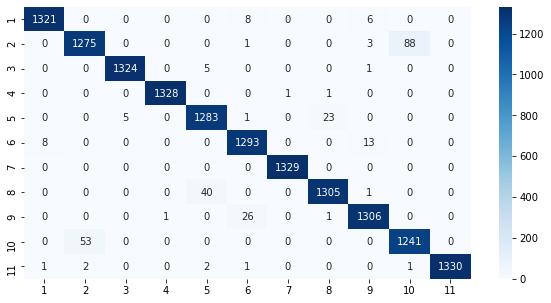

In [15]:
plt.figure(figsize=(10, 5))

sns.heatmap(pd.DataFrame(confusion_matrix(svm.predict(X_test[:, most_imp.index]), y_test), 
                         index = range(1,12), columns = range(1,12)),
            vmin = 0, cmap='Blues', annot=True, fmt='g')

plt.show()

In [16]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(random_state=1, multi_class = 'auto', solver = 'lbfgs', n_jobs=-1, max_iter = 10000 )

lr.fit(X_train[:, most_imp.index], y_train)

score3 = lr.score(X_test[:, most_imp.index], y_test)
score3

0.9025840853158327

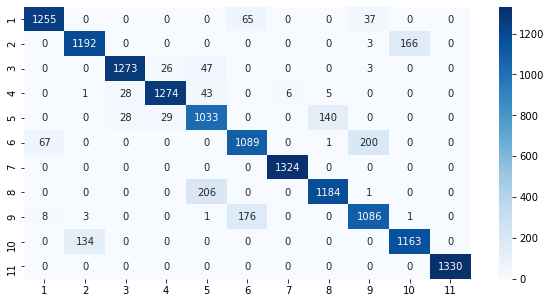

In [17]:
plt.figure(figsize=(10, 5))

sns.heatmap(pd.DataFrame(confusion_matrix(lr.predict(X_test[:, most_imp.index]), y_test), 
                         index = range(1,12), columns = range(1,12)),
            vmin = 0, cmap='Blues', annot=True, fmt='g')

plt.show()

- We have seen the scores and confusion matrices of three models and the latter two have only used 15 attributes of all the attributes
- Let's see if we can reduce the dimensions even further

In [18]:
from sklearn.decomposition import PCA

pca = PCA()

pca.fit(X_train[:, most_imp.index])

PCA()

[0.37962294 0.61738318 0.72311917 0.80677699 0.88402301 0.92571982
 0.9589819  0.98730668 0.99999334 0.99999761 0.99999941 0.99999991
 0.99999997 0.99999999 1.        ]


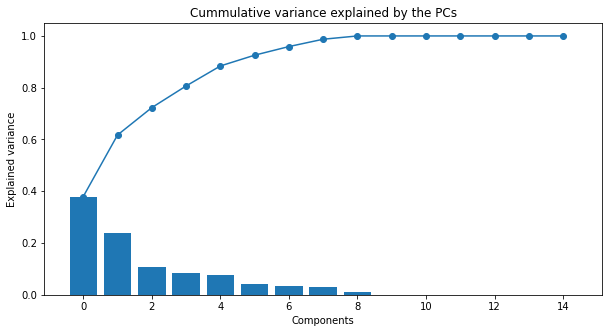

In [19]:
print(np.cumsum(pca.explained_variance_ratio_))
plt.figure(figsize=(10, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), '-o')
plt.bar(x = range(0, len(pca.components_)), height = pca.explained_variance_ratio_)
plt.title('Cummulative variance explained by the PCs')
plt.ylabel('Explained variance')
plt.xlabel('Components')
plt.show()

- The first 9 components explain 99% of the variance in the data
- This reduces our mathematical space by about 40%

In [20]:
pca = PCA(n_components=9)

pca.fit(X_train[:, most_imp.index])

PCA(n_components=9)

In [21]:
pc_train = pca.transform(X_train[:, most_imp.index])
pc_test = pca.transform(X_test[:, most_imp.index])

In [22]:
dt = DecisionTreeClassifier(random_state=1)

dt.fit(pc_train, y_train)

score4 = dt.score(pc_test, y_test)


svm = SVC(random_state=1, gamma = 'auto')

svm.fit(pc_train, y_train)

score5 = svm.score(pc_test, y_test)

lr = LogisticRegression(random_state=1, multi_class = 'auto', solver = 'lbfgs', n_jobs=-1, max_iter = 10000 )

lr.fit(pc_train, y_train)

score6 = lr.score(pc_test, y_test)

In [23]:
score4, score5, score6

(0.9799699207000273, 0.9873530216024063, 0.9023106371342631)

In [28]:
most_imp.index

Int64Index([10, 6, 11, 8, 24, 12, 19, 21, 35, 7, 31, 15, 23, 27, 9], dtype='int64', name='Feature')

In [24]:
from sklearn.pipeline import Pipeline

svm = SVC(random_state=1, gamma = 'auto')

pipe = Pipeline([('scaler', StandardScaler()), ('PCA', PCA(n_components = 9)), ('model', svm)])

In [25]:
pipe.fit(X_train[:, most_imp.index], y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('PCA', PCA(n_components=9)),
                ('model', SVC(gamma='auto', random_state=1))])

In [26]:
score7 = pipe.score(X_test[:, most_imp.index], y_test)
score7

0.9873530216024063

In [27]:
pd.DataFrame([score1, score2, score3, score4, score5, score6],
             index = ['Decision Tree with all attributes', 'SVM(imp attr)', 'Logistic Regression(imp attr)','DT(PCs)',
                      'SVM(PCs)', 'Pipline with SVM' ], columns = ['Accuracy'])

,Accuracy
Decision Tree with all attributes,0.982909
SVM(imp attr),0.979970
Logistic Regression(imp attr),0.902584
DT(PCs),0.979970
SVM(PCs),0.987353
Pipline with SVM,0.902311
